In [ ]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [ ]:
print(len(files_all))

176


In [ ]:
from multiprocessing import Pool

In [ ]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [ ]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [01:51<00:00,  1.85s/it]


In [ ]:
Dataset = 'MAP Dataset'

In [ ]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 4.294156074523926 [s] ... size 887.702213 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.154690265655518 [s] ... size 1183.602268 MB


In [ ]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [ ]:
from timeit import default_timer as timer

In [ ]:
time_all = []

In [ ]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [19]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:17<00:00,  1.30s/it]


In [20]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 32793.62it/s]


In [ ]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [37]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [08:26<00:00,  8.44s/it]


In [38]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 149885.79it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [44]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:25<00:00,  7.43s/it]


In [45]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 317951.03it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [29]:

print(len(left_files_path))

61


In [30]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [31]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:42<00:00,  1.70s/it]


In [32]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 142179.80it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [50]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 20 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:33<00:00,  2.56s/it]


In [51]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 291102.65it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [21]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [22]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [23]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [24]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [33]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:06,  8.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 73
Number of Robust matches 50



Number of matches 1001
Number of matches After Lowe's Ratio 72
Number of Robust matches 43




  7%|▋         | 4/61 [00:00<00:06,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 74
Number of Robust matches 40



Number of matches 1000
Number of matches After Lowe's Ratio 70
Number of Robust matches 31




 10%|▉         | 6/61 [00:00<00:07,  7.63it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 41
Number of Robust matches New 5



Number of matches 1003
Number of matches After Lowe's Ratio 172
Number of Robust matches 137




 11%|█▏        | 7/61 [00:00<00:06,  7.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 106
Number of Robust matches 86



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 131



Number of matches 1000
Number of matches After Lowe's Ratio 200


 16%|█▋        | 10/61 [00:01<00:06,  8.43it/s]

Number of Robust matches 168



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 165




 20%|█▉        | 12/61 [00:01<00:05,  8.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 212




 23%|██▎       | 14/61 [00:01<00:05,  8.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 192



Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 203




 26%|██▌       | 16/61 [00:01<00:05,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 212



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 219




 30%|██▉       | 18/61 [00:02<00:05,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 169



Number of matches 1001
Number of matches After Lowe's Ratio 186
Number of Robust matches 181




 33%|███▎      | 20/61 [00:02<00:04,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 201



Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 223




 36%|███▌      | 22/61 [00:02<00:04,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 237



Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 214




 39%|███▉      | 24/61 [00:02<00:04,  8.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 161



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 142




 43%|████▎     | 26/61 [00:03<00:04,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 17
Number of Robust matches 14


Number of matches After Lowe's Ratio New 62
Number of Robust matches New 19



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 356




 46%|████▌     | 28/61 [00:03<00:03,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 229



Number of matches 1001
Number of matches After Lowe's Ratio 248
Number of Robust matches 237




 49%|████▉     | 30/61 [00:03<00:03,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 213
Number of Robust matches 198



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 218




 52%|█████▏    | 32/61 [00:03<00:03,  9.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 224
Number of Robust matches 219



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 191




 56%|█████▌    | 34/61 [00:03<00:03,  8.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 224
Number of Robust matches 206



Number of matches 1002
Number of matches After Lowe's Ratio 220
Number of Robust matches 192



Number of matches 1002
Number of matches After Lowe's Ratio 288


 59%|█████▉    | 36/61 [00:04<00:02,  9.22it/s]

Number of Robust matches 281



Number of matches 1000
Number of matches After Lowe's Ratio 286
Number of Robust matches 239




 62%|██████▏   | 38/61 [00:04<00:02,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 305
Number of Robust matches 301



Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 255




 66%|██████▌   | 40/61 [00:04<00:02,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 257
Number of Robust matches 251



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 221




 69%|██████▉   | 42/61 [00:04<00:02,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 16
Number of Robust matches 11


Number of matches After Lowe's Ratio New 63
Number of Robust matches New 20



Number of matches 1000
Number of matches After Lowe's Ratio 362
Number of Robust matches 341




 72%|███████▏  | 44/61 [00:05<00:01,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 217



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 220




 75%|███████▌  | 46/61 [00:05<00:01,  8.69it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 228
Number of Robust matches 222



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 170




 79%|███████▊  | 48/61 [00:05<00:01,  9.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 195



Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 192




 82%|████████▏ | 50/61 [00:05<00:01,  8.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 165
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 198
Number of Robust matches 196




 85%|████████▌ | 52/61 [00:05<00:00,  9.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 172



Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 30




 89%|████████▊ | 54/61 [00:06<00:00,  8.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 351
Number of Robust matches 349



Number of matches 1000
Number of matches After Lowe's Ratio 203
Number of Robust matches 202




 92%|█████████▏| 56/61 [00:06<00:00,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 229
Number of Robust matches 227



Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 214




 95%|█████████▌| 58/61 [00:06<00:00,  8.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 265
Number of Robust matches 264



Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 236




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 65
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 301
Number of Robust matches 291




  3%|▎         | 2/60 [00:00<00:07,  8.28it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 77



Number of matches 1000
Number of matches After Lowe's Ratio 114
Number of Robust matches 104




  7%|▋         | 4/60 [00:00<00:06,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 120
Number of Robust matches 103



Number of matches 1000
Number of matches After Lowe's Ratio 162
Number of Robust matches 142




 10%|█         | 6/60 [00:00<00:06,  8.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 176
Number of Robust matches 150



Number of matches 1000
Number of matches After Lowe's Ratio 151
Number of Robust matches 144




 13%|█▎        | 8/60 [00:00<00:05,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 170
Number of Robust matches 155




 17%|█▋        | 10/60 [00:01<00:05,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 137



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 136




 20%|██        | 12/60 [00:01<00:05,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 151



Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 191




 23%|██▎       | 14/60 [00:01<00:05,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 247



Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 237




 27%|██▋       | 16/60 [00:01<00:05,  8.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 249
Number of Robust matches 230



Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 223




 30%|███       | 18/60 [00:02<00:04,  8.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 224
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 159




 33%|███▎      | 20/60 [00:02<00:04,  8.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 185



Number of matches 1001
Number of matches After Lowe's Ratio 356
Number of Robust matches 356




 37%|███▋      | 22/60 [00:02<00:04,  9.07it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 37
Number of Robust matches 32



Number of matches 1000
Number of matches After Lowe's Ratio 301
Number of Robust matches 297




 40%|████      | 24/60 [00:02<00:04,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 307
Number of Robust matches 304



Number of matches 1001
Number of matches After Lowe's Ratio 267
Number of Robust matches 264




 43%|████▎     | 26/60 [00:02<00:03,  9.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 211



Number of matches 1000
Number of matches After Lowe's Ratio 205
Number of Robust matches 196




 47%|████▋     | 28/60 [00:03<00:03,  9.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 194
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 185




 50%|█████     | 30/60 [00:03<00:03,  8.32it/s]


Number of matches 1001
Number of matches After Lowe's Ratio 259
Number of Robust matches 223



Number of matches 1000
Number of matches After Lowe's Ratio 230
Number of Robust matches 229




 53%|█████▎    | 32/60 [00:03<00:03,  8.67it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 201



Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 206




 57%|█████▋    | 34/60 [00:03<00:02,  8.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 204
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 164
Number of Robust matches 153




 62%|██████▏   | 37/60 [00:04<00:02,  9.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 154
Number of Robust matches 146



Number of matches 1000
Number of matches After Lowe's Ratio 176
Number of Robust matches 159



Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 136




 65%|██████▌   | 39/60 [00:04<00:02,  9.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 139



Number of matches 1000
Number of matches After Lowe's Ratio 134
Number of Robust matches 109




 68%|██████▊   | 41/60 [00:04<00:02,  9.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 112
Number of Robust matches 87



Number of matches 1000
Number of matches After Lowe's Ratio 72
Number of Robust matches 51




 72%|███████▏  | 43/60 [00:04<00:01,  8.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 79
Number of Robust matches 49



Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 51




 75%|███████▌  | 45/60 [00:05<00:01,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 78
Number of Robust matches 39



Number of matches 1000
Number of matches After Lowe's Ratio 89
Number of Robust matches 37




 78%|███████▊  | 47/60 [00:05<00:01,  8.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 86
Number of Robust matches 36



Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 55




 82%|████████▏ | 49/60 [00:05<00:01,  8.73it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 67



Number of matches 1000
Number of matches After Lowe's Ratio 222
Number of Robust matches 123




 83%|████████▎ | 50/60 [00:05<00:01,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 5
Number of Robust matches 4


Number of matches After Lowe's Ratio New 67
Number of Robust matches New 7




 87%|████████▋ | 52/60 [00:05<00:01,  7.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 64
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 117
Number of Robust matches 68




 90%|█████████ | 54/60 [00:06<00:00,  8.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 41



Number of matches 1000
Number of matches After Lowe's Ratio 110
Number of Robust matches 46




 93%|█████████▎| 56/60 [00:06<00:00,  8.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 121
Number of Robust matches 50



Number of matches 1000
Number of matches After Lowe's Ratio 128
Number of Robust matches 62




 97%|█████████▋| 58/60 [00:06<00:00,  8.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 62



Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 54




 98%|█████████▊| 59/60 [00:06<00:00,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 94
Number of Robust matches 48




In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009837150573730469 [s] ... size 0.006368 MB


In [35]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007227420806884766 [s] ... size 0.006296 MB


In [36]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [46]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 106603
Number of matches After Lowe's Ratio 54285


  2%|▏         | 1/61 [00:31<31:01, 31.03s/it]

Number of Robust matches 42531



Number of matches 106334
Number of matches After Lowe's Ratio 52062


  3%|▎         | 2/61 [01:00<30:08, 30.66s/it]

Number of Robust matches 46081



Number of matches 105432
Number of matches After Lowe's Ratio 49492


  5%|▍         | 3/61 [01:30<29:22, 30.39s/it]

Number of Robust matches 35386




  7%|▋         | 4/61 [02:00<28:51, 30.38s/it]


Number of matches 105839
Number of matches After Lowe's Ratio 23673
Number of Robust matches 15917



Number of matches 119688
Number of matches After Lowe's Ratio 1209
Number of Robust matches 16


Number of matches After Lowe's Ratio New 117


  8%|▊         | 5/61 [02:31<28:24, 30.44s/it]

Number of Robust matches New 8



Number of matches 108027
Number of matches After Lowe's Ratio 75908


 10%|▉         | 6/61 [03:03<28:25, 31.01s/it]

Number of Robust matches 67408



Number of matches 109309
Number of matches After Lowe's Ratio 58642


 11%|█▏        | 7/61 [03:35<27:57, 31.06s/it]

Number of Robust matches 53136



Number of matches 103491
Number of matches After Lowe's Ratio 57452


 13%|█▎        | 8/61 [04:05<27:18, 30.91s/it]

Number of Robust matches 54544



Number of matches 99966
Number of matches After Lowe's Ratio 57609


 15%|█▍        | 9/61 [04:34<26:09, 30.19s/it]

Number of Robust matches 52183



Number of matches 100929
Number of matches After Lowe's Ratio 58473


 16%|█▋        | 10/61 [05:02<25:19, 29.79s/it]

Number of Robust matches 52080



Number of matches 96965
Number of matches After Lowe's Ratio 56583


 18%|█▊        | 11/61 [05:31<24:31, 29.43s/it]

Number of Robust matches 54774



Number of matches 97796
Number of matches After Lowe's Ratio 57230


 20%|█▉        | 12/61 [05:59<23:38, 28.95s/it]

Number of Robust matches 52662



Number of matches 93289
Number of matches After Lowe's Ratio 54456


 21%|██▏       | 13/61 [06:26<22:46, 28.47s/it]

Number of Robust matches 45851



Number of matches 89289
Number of matches After Lowe's Ratio 54808


 23%|██▎       | 14/61 [06:52<21:41, 27.69s/it]

Number of Robust matches 51415



Number of matches 84939
Number of matches After Lowe's Ratio 53477


 25%|██▍       | 15/61 [07:17<20:34, 26.83s/it]

Number of Robust matches 44069



Number of matches 81082
Number of matches After Lowe's Ratio 50556


 26%|██▌       | 16/61 [07:41<19:26, 25.92s/it]

Number of Robust matches 45361



Number of matches 76583
Number of matches After Lowe's Ratio 46788


 28%|██▊       | 17/61 [08:02<18:03, 24.62s/it]

Number of Robust matches 42410



Number of matches 76905
Number of matches After Lowe's Ratio 47867


 30%|██▉       | 18/61 [08:23<16:53, 23.56s/it]

Number of Robust matches 40602



Number of matches 72947
Number of matches After Lowe's Ratio 44494


 31%|███       | 19/61 [08:46<16:15, 23.22s/it]

Number of Robust matches 40659



Number of matches 74374
Number of matches After Lowe's Ratio 45058


 33%|███▎      | 20/61 [09:06<15:20, 22.45s/it]

Number of Robust matches 42148



Number of matches 73778
Number of matches After Lowe's Ratio 45271


 34%|███▍      | 21/61 [09:26<14:27, 21.68s/it]

Number of Robust matches 41310



Number of matches 74743
Number of matches After Lowe's Ratio 45666


 36%|███▌      | 22/61 [09:47<13:48, 21.25s/it]

Number of Robust matches 42571



Number of matches 70418
Number of matches After Lowe's Ratio 42634


 38%|███▊      | 23/61 [10:07<13:14, 20.91s/it]

Number of Robust matches 40330




 39%|███▉      | 24/61 [10:27<12:41, 20.59s/it]


Number of matches 76297
Number of matches After Lowe's Ratio 26695
Number of Robust matches 21899



Number of matches 81745
Number of matches After Lowe's Ratio 1088
Number of Robust matches 11


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 8




 41%|████      | 25/61 [10:48<12:26, 20.74s/it]


Number of matches 81994
Number of matches After Lowe's Ratio 67580


 43%|████▎     | 26/61 [11:10<12:25, 21.29s/it]

Number of Robust matches 66563



Number of matches 74811
Number of matches After Lowe's Ratio 47829


 44%|████▍     | 27/61 [11:31<12:01, 21.23s/it]

Number of Robust matches 38914



Number of matches 75409
Number of matches After Lowe's Ratio 44747


 46%|████▌     | 28/61 [11:51<11:29, 20.90s/it]

Number of Robust matches 42363



Number of matches 79596
Number of matches After Lowe's Ratio 48530


 48%|████▊     | 29/61 [12:12<11:05, 20.81s/it]

Number of Robust matches 40091



Number of matches 76124
Number of matches After Lowe's Ratio 47925


 49%|████▉     | 30/61 [12:34<10:51, 21.00s/it]

Number of Robust matches 46753



Number of matches 76217
Number of matches After Lowe's Ratio 47227


 51%|█████     | 31/61 [12:55<10:35, 21.18s/it]

Number of Robust matches 38873



Number of matches 83683
Number of matches After Lowe's Ratio 50042


 52%|█████▏    | 32/61 [13:17<10:19, 21.36s/it]

Number of Robust matches 47683



Number of matches 84272
Number of matches After Lowe's Ratio 52081


 54%|█████▍    | 33/61 [13:41<10:23, 22.26s/it]

Number of Robust matches 48140



Number of matches 89184
Number of matches After Lowe's Ratio 55674


 56%|█████▌    | 34/61 [14:07<10:33, 23.45s/it]

Number of Robust matches 47225



Number of matches 94748
Number of matches After Lowe's Ratio 59597


 57%|█████▋    | 35/61 [14:33<10:29, 24.22s/it]

Number of Robust matches 58060



Number of matches 96673
Number of matches After Lowe's Ratio 59299


 59%|█████▉    | 36/61 [15:03<10:43, 25.72s/it]

Number of Robust matches 57332



Number of matches 98579
Number of matches After Lowe's Ratio 61364


 61%|██████    | 37/61 [15:31<10:37, 26.58s/it]

Number of Robust matches 58123



Number of matches 103800
Number of matches After Lowe's Ratio 62297


 62%|██████▏   | 38/61 [16:01<10:32, 27.49s/it]

Number of Robust matches 50911



Number of matches 101213
Number of matches After Lowe's Ratio 60555


 64%|██████▍   | 39/61 [16:30<10:16, 28.01s/it]

Number of Robust matches 58411



Number of matches 114472
Number of matches After Lowe's Ratio 37373


 66%|██████▌   | 40/61 [17:00<10:00, 28.59s/it]

Number of Robust matches 30061



Number of matches 110024
Number of matches After Lowe's Ratio 1104
Number of Robust matches 10


Number of matches After Lowe's Ratio New 81


 67%|██████▋   | 41/61 [17:32<09:53, 29.67s/it]

Number of Robust matches New 8



Number of matches 102699
Number of matches After Lowe's Ratio 79932


 69%|██████▉   | 42/61 [18:02<09:26, 29.84s/it]

Number of Robust matches 70897



Number of matches 98780
Number of matches After Lowe's Ratio 63044


 70%|███████   | 43/61 [18:31<08:49, 29.43s/it]

Number of Robust matches 59745



Number of matches 94860
Number of matches After Lowe's Ratio 61856


 72%|███████▏  | 44/61 [19:00<08:16, 29.22s/it]

Number of Robust matches 58110



Number of matches 91186
Number of matches After Lowe's Ratio 59550


 74%|███████▍  | 45/61 [19:26<07:33, 28.32s/it]

Number of Robust matches 57491



Number of matches 90799
Number of matches After Lowe's Ratio 59142


 75%|███████▌  | 46/61 [19:51<06:52, 27.49s/it]

Number of Robust matches 47498



Number of matches 91372
Number of matches After Lowe's Ratio 59475


 77%|███████▋  | 47/61 [20:17<06:17, 26.97s/it]

Number of Robust matches 54672



Number of matches 92643
Number of matches After Lowe's Ratio 59580


 79%|███████▊  | 48/61 [20:43<05:44, 26.50s/it]

Number of Robust matches 54050



Number of matches 89574
Number of matches After Lowe's Ratio 54425


 80%|████████  | 49/61 [21:08<05:12, 26.05s/it]

Number of Robust matches 52451



Number of matches 88725
Number of matches After Lowe's Ratio 52725


 82%|████████▏ | 50/61 [21:33<04:44, 25.85s/it]

Number of Robust matches 50492



Number of matches 98844
Number of matches After Lowe's Ratio 30366


 84%|████████▎ | 51/61 [21:59<04:20, 26.02s/it]

Number of Robust matches 22749



Number of matches 93535
Number of matches After Lowe's Ratio 1089
Number of Robust matches 17


Number of matches After Lowe's Ratio New 103


 85%|████████▌ | 52/61 [22:27<03:58, 26.46s/it]

Number of Robust matches New 8



Number of matches 92816
Number of matches After Lowe's Ratio 76089


 87%|████████▋ | 53/61 [22:52<03:28, 26.07s/it]

Number of Robust matches 74603



Number of matches 81086
Number of matches After Lowe's Ratio 53794


 89%|████████▊ | 54/61 [23:16<02:57, 25.36s/it]

Number of Robust matches 52667



Number of matches 85077
Number of matches After Lowe's Ratio 54423


 90%|█████████ | 55/61 [23:37<02:24, 24.15s/it]

Number of Robust matches 44115



Number of matches 84639
Number of matches After Lowe's Ratio 53948


 92%|█████████▏| 56/61 [24:02<02:02, 24.41s/it]

Number of Robust matches 51914



Number of matches 87609
Number of matches After Lowe's Ratio 54466


 93%|█████████▎| 57/61 [24:28<01:38, 24.73s/it]

Number of Robust matches 46543



Number of matches 97597
Number of matches After Lowe's Ratio 33845


 95%|█████████▌| 58/61 [24:53<01:15, 25.07s/it]

Number of Robust matches 29580



Number of matches 89680
Number of matches After Lowe's Ratio 1138
Number of Robust matches 11


Number of matches After Lowe's Ratio New 108


 97%|█████████▋| 59/61 [25:20<00:50, 25.47s/it]

Number of Robust matches New 10



Number of matches 87234
Number of matches After Lowe's Ratio 61037


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 58421



Number of matches 110798
Number of matches After Lowe's Ratio 57596


  2%|▏         | 1/60 [00:29<29:07, 29.62s/it]

Number of Robust matches 52710



Number of matches 107630
Number of matches After Lowe's Ratio 56137


  3%|▎         | 2/60 [00:59<28:45, 29.75s/it]

Number of Robust matches 51347



Number of matches 106796
Number of matches After Lowe's Ratio 55885


  5%|▌         | 3/60 [01:29<28:20, 29.83s/it]

Number of Robust matches 52952



Number of matches 97566
Number of matches After Lowe's Ratio 51627


  7%|▋         | 4/60 [01:58<27:35, 29.57s/it]

Number of Robust matches 47588



Number of matches 104030
Number of matches After Lowe's Ratio 54977


  8%|▊         | 5/60 [02:27<26:50, 29.28s/it]

Number of Robust matches 43952



Number of matches 99186
Number of matches After Lowe's Ratio 53075


 10%|█         | 6/60 [02:55<26:10, 29.08s/it]

Number of Robust matches 50477



Number of matches 94009
Number of matches After Lowe's Ratio 51048


 12%|█▏        | 7/60 [03:23<25:10, 28.50s/it]

Number of Robust matches 44513



Number of matches 90082
Number of matches After Lowe's Ratio 50585


 13%|█▎        | 8/60 [03:48<23:49, 27.48s/it]

Number of Robust matches 37571



Number of matches 87139
Number of matches After Lowe's Ratio 51555


 15%|█▌        | 9/60 [04:12<22:35, 26.59s/it]

Number of Robust matches 46410



Number of matches 86494
Number of matches After Lowe's Ratio 50708


 17%|█▋        | 10/60 [04:37<21:45, 26.11s/it]

Number of Robust matches 42418



Number of matches 79326
Number of matches After Lowe's Ratio 47162


 18%|█▊        | 11/60 [05:00<20:25, 25.02s/it]

Number of Robust matches 43662



Number of matches 76840
Number of matches After Lowe's Ratio 46010


 20%|██        | 12/60 [05:20<19:00, 23.76s/it]

Number of Robust matches 41384



Number of matches 73762
Number of matches After Lowe's Ratio 44036


 22%|██▏       | 13/60 [05:40<17:40, 22.57s/it]

Number of Robust matches 35686



Number of matches 70873
Number of matches After Lowe's Ratio 42914


 23%|██▎       | 14/60 [05:59<16:31, 21.56s/it]

Number of Robust matches 39427



Number of matches 68437
Number of matches After Lowe's Ratio 41016


 25%|██▌       | 15/60 [06:18<15:34, 20.77s/it]

Number of Robust matches 39313



Number of matches 69148
Number of matches After Lowe's Ratio 41046


 27%|██▋       | 16/60 [06:36<14:37, 19.94s/it]

Number of Robust matches 33842



Number of matches 70811
Number of matches After Lowe's Ratio 42956


 28%|██▊       | 17/60 [06:54<13:53, 19.38s/it]

Number of Robust matches 40606



Number of matches 64670
Number of matches After Lowe's Ratio 40212


 30%|███       | 18/60 [07:12<13:15, 18.93s/it]

Number of Robust matches 36611



Number of matches 67073
Number of matches After Lowe's Ratio 43228


 32%|███▏      | 19/60 [07:29<12:33, 18.37s/it]

Number of Robust matches 40684



Number of matches 69646
Number of matches After Lowe's Ratio 56225


 33%|███▎      | 20/60 [07:48<12:15, 18.38s/it]

Number of Robust matches 55289




 35%|███▌      | 21/60 [08:07<12:01, 18.51s/it]


Number of matches 71961
Number of matches After Lowe's Ratio 1223
Number of Robust matches 10


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 7



Number of matches 66621
Number of matches After Lowe's Ratio 25712


 37%|███▋      | 22/60 [08:25<11:39, 18.40s/it]

Number of Robust matches 24046



Number of matches 66191
Number of matches After Lowe's Ratio 40403


 38%|███▊      | 23/60 [08:42<11:13, 18.20s/it]

Number of Robust matches 36929



Number of matches 67499
Number of matches After Lowe's Ratio 42410


 40%|████      | 24/60 [09:00<10:49, 18.03s/it]

Number of Robust matches 41613



Number of matches 68396
Number of matches After Lowe's Ratio 41750


 42%|████▏     | 25/60 [09:18<10:30, 18.00s/it]

Number of Robust matches 35848



Number of matches 69219
Number of matches After Lowe's Ratio 42073


 43%|████▎     | 26/60 [09:37<10:17, 18.16s/it]

Number of Robust matches 40330



Number of matches 70312
Number of matches After Lowe's Ratio 41190


 45%|████▌     | 27/60 [09:55<10:04, 18.30s/it]

Number of Robust matches 36809



Number of matches 75018
Number of matches After Lowe's Ratio 42253


 47%|████▋     | 28/60 [10:14<09:52, 18.52s/it]

Number of Robust matches 39222



Number of matches 80323
Number of matches After Lowe's Ratio 46725


 48%|████▊     | 29/60 [10:34<09:46, 18.93s/it]

Number of Robust matches 45407



Number of matches 83180
Number of matches After Lowe's Ratio 47572


 50%|█████     | 30/60 [10:56<09:54, 19.83s/it]

Number of Robust matches 45340



Number of matches 88322
Number of matches After Lowe's Ratio 48787


 52%|█████▏    | 31/60 [11:21<10:21, 21.44s/it]

Number of Robust matches 38425



Number of matches 90868
Number of matches After Lowe's Ratio 55360


 53%|█████▎    | 32/60 [11:47<10:39, 22.85s/it]

Number of Robust matches 53821



Number of matches 90319
Number of matches After Lowe's Ratio 51209


 55%|█████▌    | 33/60 [12:13<10:41, 23.77s/it]

Number of Robust matches 47585



Number of matches 94916
Number of matches After Lowe's Ratio 52334


 57%|█████▋    | 34/60 [12:39<10:34, 24.40s/it]

Number of Robust matches 49499



Number of matches 96451
Number of matches After Lowe's Ratio 52243


 58%|█████▊    | 35/60 [13:08<10:40, 25.63s/it]

Number of Robust matches 43076



Number of matches 102262
Number of matches After Lowe's Ratio 55280


 60%|██████    | 36/60 [13:36<10:34, 26.42s/it]

Number of Robust matches 52551



Number of matches 105924
Number of matches After Lowe's Ratio 56343


 62%|██████▏   | 37/60 [14:05<10:25, 27.20s/it]

Number of Robust matches 54528



Number of matches 106410
Number of matches After Lowe's Ratio 57319


 63%|██████▎   | 38/60 [14:35<10:14, 27.95s/it]

Number of Robust matches 54076



Number of matches 117383
Number of matches After Lowe's Ratio 61728


 65%|██████▌   | 39/60 [15:06<10:06, 28.87s/it]

Number of Robust matches 53203



Number of matches 118869
Number of matches After Lowe's Ratio 60517


 67%|██████▋   | 40/60 [15:38<10:00, 30.04s/it]

Number of Robust matches 53675



Number of matches 114341
Number of matches After Lowe's Ratio 58949


 68%|██████▊   | 41/60 [16:11<09:44, 30.74s/it]

Number of Robust matches 53050



Number of matches 108318
Number of matches After Lowe's Ratio 56161


 70%|███████   | 42/60 [16:42<09:14, 30.81s/it]

Number of Robust matches 49553



Number of matches 102661
Number of matches After Lowe's Ratio 50405


 72%|███████▏  | 43/60 [17:11<08:36, 30.37s/it]

Number of Robust matches 43632



Number of matches 103197
Number of matches After Lowe's Ratio 46262


 73%|███████▎  | 44/60 [17:40<07:57, 29.86s/it]

Number of Robust matches 34512



Number of matches 98075
Number of matches After Lowe's Ratio 42599


 75%|███████▌  | 45/60 [18:07<07:16, 29.13s/it]

Number of Robust matches 33926



Number of matches 96346
Number of matches After Lowe's Ratio 39570


 77%|███████▋  | 46/60 [18:34<06:37, 28.37s/it]

Number of Robust matches 22356



Number of matches 96130
Number of matches After Lowe's Ratio 38602


 78%|███████▊  | 47/60 [19:01<06:05, 28.12s/it]

Number of Robust matches 24028



Number of matches 93873
Number of matches After Lowe's Ratio 38566


 80%|████████  | 48/60 [19:29<05:35, 27.99s/it]

Number of Robust matches 25266



Number of matches 91467
Number of matches After Lowe's Ratio 50340


 82%|████████▏ | 49/60 [19:54<04:58, 27.10s/it]

Number of Robust matches 29384




 83%|████████▎ | 50/60 [20:16<04:15, 25.51s/it]


Number of matches 66162
Number of matches After Lowe's Ratio 879
Number of Robust matches 18


Number of matches After Lowe's Ratio New 115
Number of Robust matches New 18




 85%|████████▌ | 51/60 [20:33<03:27, 23.05s/it]


Number of matches 65775
Number of matches After Lowe's Ratio 13085
Number of Robust matches 9246



Number of matches 81718
Number of matches After Lowe's Ratio 30984


 87%|████████▋ | 52/60 [20:52<02:53, 21.71s/it]

Number of Robust matches 25647



Number of matches 93075
Number of matches After Lowe's Ratio 37038


 88%|████████▊ | 53/60 [21:16<02:37, 22.55s/it]

Number of Robust matches 25406



Number of matches 81791
Number of matches After Lowe's Ratio 34968


 90%|█████████ | 54/60 [21:40<02:17, 22.89s/it]

Number of Robust matches 27255



Number of matches 82320
Number of matches After Lowe's Ratio 31723


 92%|█████████▏| 55/60 [22:01<01:51, 22.37s/it]

Number of Robust matches 20780



Number of matches 82796
Number of matches After Lowe's Ratio 31765


 93%|█████████▎| 56/60 [22:22<01:27, 21.82s/it]

Number of Robust matches 22318



Number of matches 89259
Number of matches After Lowe's Ratio 34606


 95%|█████████▌| 57/60 [22:43<01:05, 21.69s/it]

Number of Robust matches 23560



Number of matches 90199
Number of matches After Lowe's Ratio 37631


 97%|█████████▋| 58/60 [23:06<00:44, 22.22s/it]

Number of Robust matches 25607



Number of matches 98751
Number of matches After Lowe's Ratio 45555


 98%|█████████▊| 59/60 [23:32<00:23, 23.17s/it]

Number of Robust matches 37323




In [47]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0060999393463134766 [s] ... size 0.006368 MB


In [48]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00463414192199707 [s] ... size 0.006296 MB


In [49]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [40]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 123718
Number of matches After Lowe's Ratio 47963


  2%|▏         | 1/61 [00:33<33:54, 33.90s/it]

Number of Robust matches 38791



Number of matches 123349
Number of matches After Lowe's Ratio 45444


  3%|▎         | 2/61 [01:07<33:21, 33.93s/it]

Number of Robust matches 41059



Number of matches 122563
Number of matches After Lowe's Ratio 43082


  5%|▍         | 3/61 [01:42<32:58, 34.11s/it]

Number of Robust matches 36929



Number of matches 123146
Number of matches After Lowe's Ratio 12521


  7%|▋         | 4/61 [02:17<32:32, 34.25s/it]

Number of Robust matches 9968



Number of matches 140141
Number of matches After Lowe's Ratio 107
Number of Robust matches 9


Number of matches After Lowe's Ratio New 107


  8%|▊         | 5/61 [02:52<32:27, 34.77s/it]

Number of Robust matches New 9



Number of matches 124801
Number of matches After Lowe's Ratio 73562


 10%|▉         | 6/61 [03:30<32:38, 35.61s/it]

Number of Robust matches 69522



Number of matches 126843
Number of matches After Lowe's Ratio 53494


 11%|█▏        | 7/61 [04:04<31:43, 35.24s/it]

Number of Robust matches 48590



Number of matches 119482
Number of matches After Lowe's Ratio 53373


 13%|█▎        | 8/61 [04:39<30:59, 35.09s/it]

Number of Robust matches 41853



Number of matches 114974
Number of matches After Lowe's Ratio 53888


 15%|█▍        | 9/61 [05:10<29:22, 33.90s/it]

Number of Robust matches 51947



Number of matches 116628
Number of matches After Lowe's Ratio 54725


 16%|█▋        | 10/61 [05:41<27:53, 32.81s/it]

Number of Robust matches 45775



Number of matches 111262
Number of matches After Lowe's Ratio 52537


 18%|█▊        | 11/61 [06:11<26:48, 32.16s/it]

Number of Robust matches 51658



Number of matches 112339
Number of matches After Lowe's Ratio 53974


 20%|█▉        | 12/61 [06:41<25:43, 31.50s/it]

Number of Robust matches 52457



Number of matches 106639
Number of matches After Lowe's Ratio 50473


 21%|██▏       | 13/61 [07:10<24:34, 30.72s/it]

Number of Robust matches 49367



Number of matches 102052
Number of matches After Lowe's Ratio 51533


 23%|██▎       | 14/61 [07:38<23:29, 30.00s/it]

Number of Robust matches 48275



Number of matches 97176
Number of matches After Lowe's Ratio 50170


 25%|██▍       | 15/61 [08:07<22:36, 29.48s/it]

Number of Robust matches 46267



Number of matches 92898
Number of matches After Lowe's Ratio 47576


 26%|██▌       | 16/61 [08:33<21:25, 28.56s/it]

Number of Robust matches 43143



Number of matches 87167
Number of matches After Lowe's Ratio 42789


 28%|██▊       | 17/61 [08:58<20:11, 27.53s/it]

Number of Robust matches 42213



Number of matches 87737
Number of matches After Lowe's Ratio 43764


 30%|██▉       | 18/61 [09:22<19:01, 26.55s/it]

Number of Robust matches 41072



Number of matches 82576
Number of matches After Lowe's Ratio 40208


 31%|███       | 19/61 [09:47<18:04, 25.83s/it]

Number of Robust matches 38907



Number of matches 84294
Number of matches After Lowe's Ratio 40997


 33%|███▎      | 20/61 [10:09<16:58, 24.85s/it]

Number of Robust matches 39106



Number of matches 83467
Number of matches After Lowe's Ratio 41476


 34%|███▍      | 21/61 [10:32<16:07, 24.19s/it]

Number of Robust matches 40648



Number of matches 85101
Number of matches After Lowe's Ratio 42378


 36%|███▌      | 22/61 [10:55<15:32, 23.90s/it]

Number of Robust matches 40754



Number of matches 79743
Number of matches After Lowe's Ratio 38723


 38%|███▊      | 23/61 [11:18<14:58, 23.64s/it]

Number of Robust matches 37059



Number of matches 87186
Number of matches After Lowe's Ratio 16615


 39%|███▉      | 24/61 [11:42<14:40, 23.79s/it]

Number of Robust matches 15867




 41%|████      | 25/61 [12:06<14:18, 23.85s/it]


Number of matches 93062
Number of matches After Lowe's Ratio 103
Number of Robust matches 9


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 8



Number of matches 93815
Number of matches After Lowe's Ratio 68947


 43%|████▎     | 26/61 [12:32<14:20, 24.57s/it]

Number of Robust matches 63735



Number of matches 84368
Number of matches After Lowe's Ratio 43539


 44%|████▍     | 27/61 [12:58<14:01, 24.74s/it]

Number of Robust matches 42620



Number of matches 85343
Number of matches After Lowe's Ratio 40980


 46%|████▌     | 28/61 [13:21<13:26, 24.45s/it]

Number of Robust matches 34747



Number of matches 90551
Number of matches After Lowe's Ratio 44484


 48%|████▊     | 29/61 [13:46<12:59, 24.36s/it]

Number of Robust matches 42130



Number of matches 86161
Number of matches After Lowe's Ratio 44008


 49%|████▉     | 30/61 [14:10<12:38, 24.45s/it]

Number of Robust matches 33822



Number of matches 86252
Number of matches After Lowe's Ratio 43340


 51%|█████     | 31/61 [14:34<12:06, 24.22s/it]

Number of Robust matches 40953



Number of matches 95121
Number of matches After Lowe's Ratio 46560


 52%|█████▏    | 32/61 [14:58<11:45, 24.33s/it]

Number of Robust matches 35649



Number of matches 95586
Number of matches After Lowe's Ratio 48880


 54%|█████▍    | 33/61 [15:25<11:35, 24.85s/it]

Number of Robust matches 48223



Number of matches 101825
Number of matches After Lowe's Ratio 52974


 56%|█████▌    | 34/61 [15:52<11:34, 25.72s/it]

Number of Robust matches 45846



Number of matches 108236
Number of matches After Lowe's Ratio 56968


 57%|█████▋    | 35/61 [16:22<11:41, 26.97s/it]

Number of Robust matches 51391



Number of matches 110307
Number of matches After Lowe's Ratio 55902


 59%|█████▉    | 36/61 [16:53<11:44, 28.17s/it]

Number of Robust matches 54313



Number of matches 112785
Number of matches After Lowe's Ratio 58506


 61%|██████    | 37/61 [17:24<11:35, 28.98s/it]

Number of Robust matches 48694



Number of matches 119231
Number of matches After Lowe's Ratio 58903


 62%|██████▏   | 38/61 [17:56<11:28, 29.96s/it]

Number of Robust matches 47702



Number of matches 115576
Number of matches After Lowe's Ratio 56149


 64%|██████▍   | 39/61 [18:29<11:18, 30.82s/it]

Number of Robust matches 53629




 66%|██████▌   | 40/61 [19:03<11:06, 31.73s/it]


Number of matches 132956
Number of matches After Lowe's Ratio 21713
Number of Robust matches 20244



Number of matches 128018
Number of matches After Lowe's Ratio 87
Number of Robust matches 7


Number of matches After Lowe's Ratio New 87


 67%|██████▋   | 41/61 [19:39<10:59, 32.99s/it]

Number of Robust matches New 6



Number of matches 118348
Number of matches After Lowe's Ratio 80976


 69%|██████▉   | 42/61 [20:14<10:41, 33.77s/it]

Number of Robust matches 80265



Number of matches 113534
Number of matches After Lowe's Ratio 59363


 70%|███████   | 43/61 [20:47<10:02, 33.48s/it]

Number of Robust matches 57579



Number of matches 108975
Number of matches After Lowe's Ratio 58899


 72%|███████▏  | 44/61 [21:19<09:21, 33.05s/it]

Number of Robust matches 50413



Number of matches 104398
Number of matches After Lowe's Ratio 56334


 74%|███████▍  | 45/61 [21:50<08:37, 32.37s/it]

Number of Robust matches 53345



Number of matches 103620
Number of matches After Lowe's Ratio 55686


 75%|███████▌  | 46/61 [22:20<07:53, 31.57s/it]

Number of Robust matches 54946



Number of matches 104194
Number of matches After Lowe's Ratio 56108


 77%|███████▋  | 47/61 [22:49<07:14, 31.01s/it]

Number of Robust matches 54955



Number of matches 105932
Number of matches After Lowe's Ratio 55339


 79%|███████▊  | 48/61 [23:20<06:41, 30.86s/it]

Number of Robust matches 53169



Number of matches 102424
Number of matches After Lowe's Ratio 49395


 80%|████████  | 49/61 [23:50<06:08, 30.68s/it]

Number of Robust matches 48543



Number of matches 101402
Number of matches After Lowe's Ratio 47989


 82%|████████▏ | 50/61 [24:20<05:33, 30.30s/it]

Number of Robust matches 46494




 84%|████████▎ | 51/61 [24:50<05:02, 30.23s/it]


Number of matches 113915
Number of matches After Lowe's Ratio 18286
Number of Robust matches 17212



Number of matches 107817
Number of matches After Lowe's Ratio 101
Number of Robust matches 7


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 7




 85%|████████▌ | 52/61 [25:21<04:35, 30.58s/it]


Number of matches 106929
Number of matches After Lowe's Ratio 76684


 87%|████████▋ | 53/61 [25:52<04:04, 30.53s/it]

Number of Robust matches 75605



Number of matches 92022
Number of matches After Lowe's Ratio 48960


 89%|████████▊ | 54/61 [26:18<03:26, 29.44s/it]

Number of Robust matches 42542



Number of matches 97272
Number of matches After Lowe's Ratio 50496


 90%|█████████ | 55/61 [26:43<02:48, 28.04s/it]

Number of Robust matches 49065



Number of matches 96511
Number of matches After Lowe's Ratio 50331


 92%|█████████▏| 56/61 [27:09<02:16, 27.35s/it]

Number of Robust matches 49779



Number of matches 100032
Number of matches After Lowe's Ratio 50726


 93%|█████████▎| 57/61 [27:37<01:50, 27.67s/it]

Number of Robust matches 47952




 95%|█████████▌| 58/61 [28:07<01:24, 28.32s/it]


Number of matches 112557
Number of matches After Lowe's Ratio 21055
Number of Robust matches 19122



Number of matches 103171
Number of matches After Lowe's Ratio 107
Number of Robust matches 9


Number of matches After Lowe's Ratio New 107


 97%|█████████▋| 59/61 [28:38<00:57, 28.93s/it]

Number of Robust matches New 8



Number of matches 100490
Number of matches After Lowe's Ratio 55158


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches 51252



Number of matches 128923
Number of matches After Lowe's Ratio 51196


  2%|▏         | 1/60 [00:34<34:09, 34.74s/it]

Number of Robust matches 44894



Number of matches 124297
Number of matches After Lowe's Ratio 49502


  3%|▎         | 2/60 [01:10<33:47, 34.96s/it]

Number of Robust matches 47427



Number of matches 123834
Number of matches After Lowe's Ratio 50640


  5%|▌         | 3/60 [01:44<33:00, 34.75s/it]

Number of Robust matches 41765



Number of matches 111664
Number of matches After Lowe's Ratio 46059


  7%|▋         | 4/60 [02:17<32:00, 34.29s/it]

Number of Robust matches 41977



Number of matches 120200
Number of matches After Lowe's Ratio 50012


  8%|▊         | 5/60 [02:49<30:48, 33.60s/it]

Number of Robust matches 48570



Number of matches 114436
Number of matches After Lowe's Ratio 48478


 10%|█         | 6/60 [03:22<30:09, 33.50s/it]

Number of Robust matches 47785



Number of matches 107849
Number of matches After Lowe's Ratio 46734


 12%|█▏        | 7/60 [03:54<29:05, 32.93s/it]

Number of Robust matches 40872



Number of matches 103152
Number of matches After Lowe's Ratio 45559


 13%|█▎        | 8/60 [04:24<27:43, 32.00s/it]

Number of Robust matches 39076



Number of matches 99278
Number of matches After Lowe's Ratio 46543


 15%|█▌        | 9/60 [04:53<26:25, 31.09s/it]

Number of Robust matches 45947



Number of matches 98570
Number of matches After Lowe's Ratio 45859


 17%|█▋        | 10/60 [05:21<25:12, 30.25s/it]

Number of Robust matches 34483



Number of matches 90116
Number of matches After Lowe's Ratio 42522


 18%|█▊        | 11/60 [05:46<23:29, 28.77s/it]

Number of Robust matches 40603



Number of matches 87241
Number of matches After Lowe's Ratio 41557


 20%|██        | 12/60 [06:12<22:07, 27.66s/it]

Number of Robust matches 34537



Number of matches 83638
Number of matches After Lowe's Ratio 39714


 22%|██▏       | 13/60 [06:35<20:43, 26.45s/it]

Number of Robust matches 37388



Number of matches 80078
Number of matches After Lowe's Ratio 39189


 23%|██▎       | 14/60 [06:58<19:30, 25.45s/it]

Number of Robust matches 38719



Number of matches 77102
Number of matches After Lowe's Ratio 37140


 25%|██▌       | 15/60 [07:20<18:17, 24.39s/it]

Number of Robust matches 36231



Number of matches 77974
Number of matches After Lowe's Ratio 37453


 27%|██▋       | 16/60 [07:42<17:17, 23.58s/it]

Number of Robust matches 36305



Number of matches 79923
Number of matches After Lowe's Ratio 39536


 28%|██▊       | 17/60 [08:04<16:29, 23.01s/it]

Number of Robust matches 36775



Number of matches 72552
Number of matches After Lowe's Ratio 36958


 30%|███       | 18/60 [08:25<15:52, 22.69s/it]

Number of Robust matches 33750



Number of matches 75565
Number of matches After Lowe's Ratio 41066


 32%|███▏      | 19/60 [08:46<15:05, 22.09s/it]

Number of Robust matches 34767



Number of matches 78536
Number of matches After Lowe's Ratio 56988


 33%|███▎      | 20/60 [09:08<14:39, 21.99s/it]

Number of Robust matches 51568




 35%|███▌      | 21/60 [09:29<14:08, 21.75s/it]


Number of matches 81312
Number of matches After Lowe's Ratio 120
Number of Robust matches 11


Number of matches After Lowe's Ratio New 120
Number of Robust matches New 10




 37%|███▋      | 22/60 [09:51<13:43, 21.67s/it]


Number of matches 74678
Number of matches After Lowe's Ratio 16384
Number of Robust matches 15059



Number of matches 74369
Number of matches After Lowe's Ratio 37801


 38%|███▊      | 23/60 [10:12<13:18, 21.58s/it]

Number of Robust matches 32291



Number of matches 75878
Number of matches After Lowe's Ratio 39854


 40%|████      | 24/60 [10:33<12:53, 21.49s/it]

Number of Robust matches 39263



Number of matches 76935
Number of matches After Lowe's Ratio 38852


 42%|████▏     | 25/60 [10:55<12:37, 21.63s/it]

Number of Robust matches 37066



Number of matches 78183
Number of matches After Lowe's Ratio 39264


 43%|████▎     | 26/60 [11:16<12:08, 21.41s/it]

Number of Robust matches 38876



Number of matches 79460
Number of matches After Lowe's Ratio 37570


 45%|████▌     | 27/60 [11:38<11:46, 21.41s/it]

Number of Robust matches 37026



Number of matches 85086
Number of matches After Lowe's Ratio 38288


 47%|████▋     | 28/60 [12:00<11:37, 21.78s/it]

Number of Robust matches 33629



Number of matches 91780
Number of matches After Lowe's Ratio 42735


 48%|████▊     | 29/60 [12:24<11:29, 22.25s/it]

Number of Robust matches 41159



Number of matches 95267
Number of matches After Lowe's Ratio 43501


 50%|█████     | 30/60 [12:49<11:36, 23.21s/it]

Number of Robust matches 42438



Number of matches 101222
Number of matches After Lowe's Ratio 44215


 52%|█████▏    | 31/60 [13:18<12:03, 24.94s/it]

Number of Robust matches 41971



Number of matches 103900
Number of matches After Lowe's Ratio 51767


 53%|█████▎    | 32/60 [13:48<12:25, 26.61s/it]

Number of Robust matches 51193



Number of matches 102986
Number of matches After Lowe's Ratio 46129


 55%|█████▌    | 33/60 [14:19<12:33, 27.92s/it]

Number of Robust matches 43122



Number of matches 109235
Number of matches After Lowe's Ratio 46810


 57%|█████▋    | 34/60 [14:51<12:31, 28.90s/it]

Number of Robust matches 40115



Number of matches 111034
Number of matches After Lowe's Ratio 46089


 58%|█████▊    | 35/60 [15:24<12:33, 30.16s/it]

Number of Robust matches 42480



Number of matches 118662
Number of matches After Lowe's Ratio 50008


 60%|██████    | 36/60 [15:57<12:25, 31.06s/it]

Number of Robust matches 43215



Number of matches 122752
Number of matches After Lowe's Ratio 50668


 62%|██████▏   | 37/60 [16:32<12:20, 32.21s/it]

Number of Robust matches 42916



Number of matches 123239
Number of matches After Lowe's Ratio 51298


 63%|██████▎   | 38/60 [17:07<12:09, 33.16s/it]

Number of Robust matches 45177



Number of matches 137507
Number of matches After Lowe's Ratio 54997


 65%|██████▌   | 39/60 [17:45<12:07, 34.62s/it]

Number of Robust matches 52835



Number of matches 138567
Number of matches After Lowe's Ratio 53999


 67%|██████▋   | 40/60 [18:24<11:57, 35.88s/it]

Number of Robust matches 43326



Number of matches 132902
Number of matches After Lowe's Ratio 52059


 68%|██████▊   | 41/60 [19:02<11:35, 36.63s/it]

Number of Robust matches 46901



Number of matches 126306
Number of matches After Lowe's Ratio 48779


 70%|███████   | 42/60 [19:38<10:56, 36.45s/it]

Number of Robust matches 43172



Number of matches 119405
Number of matches After Lowe's Ratio 43117


 72%|███████▏  | 43/60 [20:13<10:09, 35.82s/it]

Number of Robust matches 39729



Number of matches 120498
Number of matches After Lowe's Ratio 39098


 73%|███████▎  | 44/60 [20:47<09:25, 35.36s/it]

Number of Robust matches 31518



Number of matches 114196
Number of matches After Lowe's Ratio 35317


 75%|███████▌  | 45/60 [21:21<08:41, 34.79s/it]

Number of Robust matches 29561



Number of matches 111832
Number of matches After Lowe's Ratio 32445


 77%|███████▋  | 46/60 [21:54<08:00, 34.36s/it]

Number of Robust matches 24388



Number of matches 110612
Number of matches After Lowe's Ratio 30426


 78%|███████▊  | 47/60 [22:26<07:16, 33.62s/it]

Number of Robust matches 21288



Number of matches 107590
Number of matches After Lowe's Ratio 30254


 80%|████████  | 48/60 [22:57<06:36, 33.05s/it]

Number of Robust matches 21440



Number of matches 105704
Number of matches After Lowe's Ratio 41760


 82%|████████▏ | 49/60 [23:29<05:58, 32.64s/it]

Number of Robust matches 24195




 83%|████████▎ | 50/60 [23:55<05:04, 30.49s/it]


Number of matches 76953
Number of matches After Lowe's Ratio 116
Number of Robust matches 15


Number of matches After Lowe's Ratio New 116
Number of Robust matches New 13




 85%|████████▌ | 51/60 [24:15<04:06, 27.44s/it]


Number of matches 74782
Number of matches After Lowe's Ratio 6605
Number of Robust matches 6008



Number of matches 93578
Number of matches After Lowe's Ratio 24958


 87%|████████▋ | 52/60 [24:38<03:28, 26.04s/it]

Number of Robust matches 19538



Number of matches 107542
Number of matches After Lowe's Ratio 29967
Number of Robust matches 20224




 90%|█████████ | 54/60 [25:34<02:42, 27.15s/it]


Number of matches 93786
Number of matches After Lowe's Ratio 27639
Number of Robust matches 23851



Number of matches 94712
Number of matches After Lowe's Ratio 25201


 92%|█████████▏| 55/60 [26:00<02:13, 26.71s/it]

Number of Robust matches 18320




 93%|█████████▎| 56/60 [26:25<01:44, 26.24s/it]


Number of matches 95362
Number of matches After Lowe's Ratio 24920
Number of Robust matches 18673



Number of matches 103843
Number of matches After Lowe's Ratio 27696
Number of Robust matches 21727




 95%|█████████▌| 57/60 [26:53<01:19, 26.57s/it]


Number of matches 104889
Number of matches After Lowe's Ratio 30219


 97%|█████████▋| 58/60 [27:22<00:55, 27.54s/it]

Number of Robust matches 21674



Number of matches 114556
Number of matches After Lowe's Ratio 37881


 98%|█████████▊| 59/60 [27:53<00:28, 28.49s/it]

Number of Robust matches 32135




In [41]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005986928939819336 [s] ... size 0.006368 MB


In [42]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004784107208251953 [s] ... size 0.006296 MB


In [43]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [25]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:29,  8.49s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 868
Number of Robust matches 734




  3%|▎         | 2/61 [00:16<08:17,  8.43s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 834
Number of Robust matches 675




  5%|▍         | 3/61 [00:25<08:15,  8.55s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 827
Number of Robust matches 756




  7%|▋         | 4/61 [00:34<08:18,  8.74s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 639
Number of Robust matches 564




  8%|▊         | 5/61 [00:43<08:14,  8.83s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 89
Number of Robust matches 43




 10%|▉         | 6/61 [00:52<07:57,  8.67s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 1569
Number of Robust matches 1338




 11%|█▏        | 7/61 [00:59<07:22,  8.19s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 987
Number of Robust matches 945




 13%|█▎        | 8/61 [01:06<06:53,  7.79s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 919
Number of Robust matches 874




 15%|█▍        | 9/61 [01:12<06:16,  7.25s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 983
Number of Robust matches 957




 16%|█▋        | 10/61 [01:17<05:48,  6.82s/it]


Number of matches 39124
Number of matches After Lowe's Ratio 893
Number of Robust matches 819




 18%|█▊        | 11/61 [01:23<05:21,  6.42s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 943
Number of Robust matches 903




 20%|█▉        | 12/61 [01:28<04:54,  6.01s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 968
Number of Robust matches 921




 21%|██▏       | 13/61 [01:33<04:36,  5.76s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 903
Number of Robust matches 855




 23%|██▎       | 14/61 [01:38<04:14,  5.42s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 968
Number of Robust matches 937




 25%|██▍       | 15/61 [01:42<03:54,  5.10s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 883
Number of Robust matches 849




 26%|██▌       | 16/61 [01:46<03:37,  4.83s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 810
Number of Robust matches 703




 28%|██▊       | 17/61 [01:50<03:16,  4.47s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 707
Number of Robust matches 679




 30%|██▉       | 18/61 [01:53<02:55,  4.08s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 628
Number of Robust matches 599




 31%|███       | 19/61 [01:56<02:41,  3.85s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 655
Number of Robust matches 595




 33%|███▎      | 20/61 [01:59<02:26,  3.58s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 646
Number of Robust matches 597




 34%|███▍      | 21/61 [02:02<02:16,  3.41s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 669
Number of Robust matches 630




 36%|███▌      | 22/61 [02:06<02:12,  3.38s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 692
Number of Robust matches 654




 38%|███▊      | 23/61 [02:09<02:05,  3.30s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 566
Number of Robust matches 525




 39%|███▉      | 24/61 [02:12<01:59,  3.22s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 449
Number of Robust matches 415




 41%|████      | 25/61 [02:15<01:57,  3.25s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 56
Number of Robust matches 29




 43%|████▎     | 26/61 [02:19<01:57,  3.35s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1413
Number of Robust matches 1312




 44%|████▍     | 27/61 [02:22<01:54,  3.38s/it]


Number of matches 24539
Number of matches After Lowe's Ratio 624
Number of Robust matches 595




 46%|████▌     | 28/61 [02:25<01:44,  3.18s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 616
Number of Robust matches 575




 48%|████▊     | 29/61 [02:28<01:39,  3.11s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 641
Number of Robust matches 604




 49%|████▉     | 30/61 [02:31<01:35,  3.07s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 622
Number of Robust matches 594




 51%|█████     | 31/61 [02:34<01:29,  2.97s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 680
Number of Robust matches 653




 52%|█████▏    | 32/61 [02:37<01:26,  3.00s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 714
Number of Robust matches 680




 54%|█████▍    | 33/61 [02:40<01:29,  3.19s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 809
Number of Robust matches 774




 56%|█████▌    | 34/61 [02:44<01:31,  3.40s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 909
Number of Robust matches 879




 57%|█████▋    | 35/61 [02:48<01:34,  3.65s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 997
Number of Robust matches 975




 59%|█████▉    | 36/61 [02:53<01:42,  4.09s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 955
Number of Robust matches 907




 61%|██████    | 37/61 [02:58<01:44,  4.37s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 912
Number of Robust matches 897




 62%|██████▏   | 38/61 [03:04<01:48,  4.71s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 921
Number of Robust matches 822




 64%|██████▍   | 39/61 [03:10<01:50,  5.02s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 847
Number of Robust matches 813




 66%|██████▌   | 40/61 [03:16<01:50,  5.25s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 591
Number of Robust matches 546




 67%|██████▋   | 41/61 [03:23<01:56,  5.84s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 62
Number of Robust matches 27




 69%|██████▉   | 42/61 [03:30<01:59,  6.27s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1588
Number of Robust matches 1555




 70%|███████   | 43/61 [03:36<01:53,  6.31s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 966
Number of Robust matches 938




 72%|███████▏  | 44/61 [03:42<01:44,  6.17s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 984
Number of Robust matches 899




 74%|███████▍  | 45/61 [03:48<01:35,  5.95s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 939
Number of Robust matches 919




 75%|███████▌  | 46/61 [03:53<01:24,  5.64s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 825
Number of Robust matches 793




 77%|███████▋  | 47/61 [03:57<01:15,  5.39s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 791
Number of Robust matches 771




 79%|███████▊  | 48/61 [04:02<01:07,  5.22s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 714
Number of Robust matches 674




 80%|████████  | 49/61 [04:06<00:59,  4.93s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 582
Number of Robust matches 534




 82%|████████▏ | 50/61 [04:10<00:51,  4.66s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 648
Number of Robust matches 617




 84%|████████▎ | 51/61 [04:15<00:45,  4.57s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 493
Number of Robust matches 463




 85%|████████▌ | 52/61 [04:19<00:41,  4.57s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 92
Number of Robust matches 52




 87%|████████▋ | 53/61 [04:24<00:36,  4.60s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1340
Number of Robust matches 1322




 89%|████████▊ | 54/61 [04:28<00:30,  4.39s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 622
Number of Robust matches 596




 90%|█████████ | 55/61 [04:31<00:24,  4.09s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 676
Number of Robust matches 640




 92%|█████████▏| 56/61 [04:35<00:20,  4.02s/it]


Number of matches 31476
Number of matches After Lowe's Ratio 714
Number of Robust matches 674




 93%|█████████▎| 57/61 [04:40<00:16,  4.23s/it]


Number of matches 34257
Number of matches After Lowe's Ratio 864
Number of Robust matches 840




 95%|█████████▌| 58/61 [04:45<00:13,  4.45s/it]


Number of matches 39314
Number of matches After Lowe's Ratio 696
Number of Robust matches 668




 97%|█████████▋| 59/61 [04:50<00:09,  4.77s/it]


Number of matches 35295
Number of matches After Lowe's Ratio 163
Number of Robust matches 134




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33042
Number of matches After Lowe's Ratio 1148
Number of Robust matches 1119




  2%|▏         | 1/60 [00:08<08:21,  8.50s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 912
Number of Robust matches 879




  3%|▎         | 2/60 [00:16<08:06,  8.38s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 1005
Number of Robust matches 960




  5%|▌         | 3/60 [00:23<07:39,  8.06s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 921
Number of Robust matches 905




  7%|▋         | 4/60 [00:30<07:06,  7.62s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 933
Number of Robust matches 903




  8%|▊         | 5/60 [00:36<06:33,  7.15s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 858
Number of Robust matches 834




 10%|█         | 6/60 [00:42<06:09,  6.83s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 779
Number of Robust matches 752




 12%|█▏        | 7/60 [00:47<05:34,  6.32s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 815
Number of Robust matches 791




 13%|█▎        | 8/60 [00:52<05:06,  5.90s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 782
Number of Robust matches 765




 15%|█▌        | 9/60 [00:56<04:35,  5.41s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 743
Number of Robust matches 676




 17%|█▋        | 10/60 [01:00<04:07,  4.95s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 641
Number of Robust matches 577




 18%|█▊        | 11/60 [01:04<03:46,  4.63s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 608
Number of Robust matches 597




 20%|██        | 12/60 [01:07<03:20,  4.17s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 588
Number of Robust matches 566




 22%|██▏       | 13/60 [01:10<02:56,  3.75s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 573
Number of Robust matches 535




 23%|██▎       | 14/60 [01:13<02:38,  3.45s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 645
Number of Robust matches 625




 25%|██▌       | 15/60 [01:16<02:27,  3.28s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 589
Number of Robust matches 565




 27%|██▋       | 16/60 [01:18<02:15,  3.09s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 602
Number of Robust matches 558




 28%|██▊       | 17/60 [01:21<02:06,  2.95s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 684
Number of Robust matches 638




 30%|███       | 18/60 [01:23<01:58,  2.81s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 628
Number of Robust matches 596




 32%|███▏      | 19/60 [01:26<01:50,  2.70s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 689
Number of Robust matches 662




 33%|███▎      | 20/60 [01:28<01:44,  2.62s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1329
Number of Robust matches 1301




 35%|███▌      | 21/60 [01:31<01:41,  2.61s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 80
Number of Robust matches 52




 37%|███▋      | 22/60 [01:34<01:41,  2.68s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 668
Number of Robust matches 607




 38%|███▊      | 23/60 [01:36<01:39,  2.68s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 887
Number of Robust matches 866




 40%|████      | 24/60 [01:39<01:34,  2.63s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 842
Number of Robust matches 822




 42%|████▏     | 25/60 [01:41<01:30,  2.58s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 719
Number of Robust matches 673




 43%|████▎     | 26/60 [01:44<01:27,  2.58s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 764
Number of Robust matches 719




 45%|████▌     | 27/60 [01:47<01:26,  2.63s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 614
Number of Robust matches 595




 47%|████▋     | 28/60 [01:50<01:27,  2.73s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 597
Number of Robust matches 543




 48%|████▊     | 29/60 [01:53<01:28,  2.86s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 745
Number of Robust matches 677




 50%|█████     | 30/60 [01:57<01:35,  3.17s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 714
Number of Robust matches 629




 52%|█████▏    | 31/60 [02:01<01:43,  3.56s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 701
Number of Robust matches 673




 53%|█████▎    | 32/60 [02:06<01:47,  3.83s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 913
Number of Robust matches 883




 55%|█████▌    | 33/60 [02:10<01:50,  4.11s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 781
Number of Robust matches 756




 57%|█████▋    | 34/60 [02:15<01:50,  4.24s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 831
Number of Robust matches 806




 58%|█████▊    | 35/60 [02:20<01:54,  4.59s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 799
Number of Robust matches 705




 60%|██████    | 36/60 [02:27<02:02,  5.11s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 968
Number of Robust matches 868




 62%|██████▏   | 37/60 [02:34<02:13,  5.79s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 973
Number of Robust matches 935




 63%|██████▎   | 38/60 [02:42<02:22,  6.49s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1030
Number of Robust matches 992




 65%|██████▌   | 39/60 [02:51<02:32,  7.26s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1050
Number of Robust matches 919




 67%|██████▋   | 40/60 [03:02<02:42,  8.14s/it]


Number of matches 61437
Number of matches After Lowe's Ratio 951
Number of Robust matches 904




 68%|██████▊   | 41/60 [03:12<02:46,  8.75s/it]


Number of matches 60649
Number of matches After Lowe's Ratio 979
Number of Robust matches 916




 70%|███████   | 42/60 [03:22<02:46,  9.24s/it]


Number of matches 58722
Number of matches After Lowe's Ratio 897
Number of Robust matches 773




 72%|███████▏  | 43/60 [03:32<02:38,  9.30s/it]


Number of matches 56259
Number of matches After Lowe's Ratio 843
Number of Robust matches 749




 73%|███████▎  | 44/60 [03:41<02:28,  9.31s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 774
Number of Robust matches 638




 75%|███████▌  | 45/60 [03:50<02:18,  9.20s/it]


Number of matches 55225
Number of matches After Lowe's Ratio 767
Number of Robust matches 641




 77%|███████▋  | 46/60 [03:58<02:06,  9.03s/it]


Number of matches 55319
Number of matches After Lowe's Ratio 722
Number of Robust matches 574




 78%|███████▊  | 47/60 [04:07<01:55,  8.90s/it]


Number of matches 53619
Number of matches After Lowe's Ratio 588
Number of Robust matches 412




 80%|████████  | 48/60 [04:15<01:43,  8.66s/it]


Number of matches 49915
Number of matches After Lowe's Ratio 483
Number of Robust matches 291




 82%|████████▏ | 49/60 [04:23<01:32,  8.40s/it]


Number of matches 49227
Number of matches After Lowe's Ratio 934
Number of Robust matches 420




 83%|████████▎ | 50/60 [04:29<01:16,  7.69s/it]


Number of matches 30410
Number of matches After Lowe's Ratio 93
Number of Robust matches 64




 85%|████████▌ | 51/60 [04:32<00:57,  6.43s/it]


Number of matches 28540
Number of matches After Lowe's Ratio 300
Number of Robust matches 254




 87%|████████▋ | 52/60 [04:36<00:45,  5.71s/it]


Number of matches 36887
Number of matches After Lowe's Ratio 444
Number of Robust matches 397




 88%|████████▊ | 53/60 [04:42<00:39,  5.59s/it]


Number of matches 43944
Number of matches After Lowe's Ratio 417
Number of Robust matches 345




 90%|█████████ | 54/60 [04:49<00:35,  5.95s/it]


Number of matches 40673
Number of matches After Lowe's Ratio 461
Number of Robust matches 393




 92%|█████████▏| 55/60 [04:54<00:29,  5.87s/it]


Number of matches 42349
Number of matches After Lowe's Ratio 483
Number of Robust matches 348




 93%|█████████▎| 56/60 [05:00<00:23,  5.87s/it]


Number of matches 44189
Number of matches After Lowe's Ratio 543
Number of Robust matches 381




 95%|█████████▌| 57/60 [05:08<00:19,  6.34s/it]


Number of matches 49788
Number of matches After Lowe's Ratio 533
Number of Robust matches 342




 97%|█████████▋| 58/60 [05:16<00:13,  6.84s/it]


Number of matches 49372
Number of matches After Lowe's Ratio 596
Number of Robust matches 425




 98%|█████████▊| 59/60 [05:24<00:07,  7.22s/it]


Number of matches 53005
Number of matches After Lowe's Ratio 636
Number of Robust matches 495




In [26]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006968975067138672 [s] ... size 0.006368 MB


In [27]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005924701690673828 [s] ... size 0.006296 MB


In [28]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [52]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 45303
Number of matches After Lowe's Ratio 6341


  2%|▏         | 1/61 [00:06<06:19,  6.32s/it]

Number of Robust matches 5917




  3%|▎         | 2/61 [00:12<06:07,  6.22s/it]


Number of matches 45137
Number of matches After Lowe's Ratio 5859
Number of Robust matches 5532




  5%|▍         | 3/61 [00:18<06:04,  6.28s/it]


Number of matches 44880
Number of matches After Lowe's Ratio 5295
Number of Robust matches 4209




  7%|▋         | 4/61 [00:24<05:49,  6.12s/it]


Number of matches 45767
Number of matches After Lowe's Ratio 174
Number of Robust matches 132




  8%|▊         | 5/61 [00:31<05:53,  6.31s/it]


Number of matches 48923
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2811
Number of Robust matches New 8




 10%|▉         | 6/61 [00:37<05:52,  6.40s/it]


Number of matches 46646
Number of matches After Lowe's Ratio 11019
Number of Robust matches 10426




 11%|█▏        | 7/61 [00:44<05:51,  6.50s/it]


Number of matches 47626
Number of matches After Lowe's Ratio 7024
Number of Robust matches 6223



Number of matches 46687
Number of matches After Lowe's Ratio 7507


 13%|█▎        | 8/61 [00:51<05:51,  6.63s/it]

Number of Robust matches 7386




 15%|█▍        | 9/61 [00:57<05:42,  6.58s/it]


Number of matches 46330
Number of matches After Lowe's Ratio 7856
Number of Robust matches 7358




 16%|█▋        | 10/61 [01:04<05:38,  6.65s/it]


Number of matches 47227
Number of matches After Lowe's Ratio 7856
Number of Robust matches 7700




 18%|█▊        | 11/61 [01:11<05:33,  6.67s/it]


Number of matches 46005
Number of matches After Lowe's Ratio 7975
Number of Robust matches 6955




 20%|█▉        | 12/61 [01:18<05:31,  6.76s/it]


Number of matches 46028
Number of matches After Lowe's Ratio 7627
Number of Robust matches 7578




 21%|██▏       | 13/61 [01:25<05:24,  6.75s/it]


Number of matches 45275
Number of matches After Lowe's Ratio 7406
Number of Robust matches 7280




 23%|██▎       | 14/61 [01:31<05:12,  6.65s/it]


Number of matches 44601
Number of matches After Lowe's Ratio 7654
Number of Robust matches 6936




 25%|██▍       | 15/61 [01:38<05:05,  6.64s/it]


Number of matches 43660
Number of matches After Lowe's Ratio 7608
Number of Robust matches 7456



Number of matches 44136
Number of matches After Lowe's Ratio 7483


 26%|██▌       | 16/61 [01:44<04:58,  6.62s/it]

Number of Robust matches 7431




 28%|██▊       | 17/61 [01:51<04:46,  6.50s/it]


Number of matches 43565
Number of matches After Lowe's Ratio 7454
Number of Robust matches 7413




 30%|██▉       | 18/61 [01:57<04:38,  6.47s/it]


Number of matches 44319
Number of matches After Lowe's Ratio 7491
Number of Robust matches 7016




 31%|███       | 19/61 [02:03<04:30,  6.44s/it]


Number of matches 43943
Number of matches After Lowe's Ratio 7523
Number of Robust matches 6607




 33%|███▎      | 20/61 [02:10<04:26,  6.50s/it]


Number of matches 44027
Number of matches After Lowe's Ratio 7506
Number of Robust matches 7306




 34%|███▍      | 21/61 [02:16<04:19,  6.49s/it]


Number of matches 43270
Number of matches After Lowe's Ratio 7565
Number of Robust matches 7233




 36%|███▌      | 22/61 [02:23<04:14,  6.54s/it]


Number of matches 42967
Number of matches After Lowe's Ratio 7242
Number of Robust matches 7176



Number of matches 42260
Number of matches After Lowe's Ratio 6778


 38%|███▊      | 23/61 [02:29<04:05,  6.47s/it]

Number of Robust matches 6472




 39%|███▉      | 24/61 [02:35<03:52,  6.27s/it]


Number of matches 44038
Number of matches After Lowe's Ratio 197
Number of Robust matches 141




 41%|████      | 25/61 [02:42<03:50,  6.41s/it]


Number of matches 45516
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2477
Number of Robust matches New 8




 43%|████▎     | 26/61 [02:48<03:44,  6.42s/it]


Number of matches 45667
Number of matches After Lowe's Ratio 14023
Number of Robust matches 13989




 44%|████▍     | 27/61 [02:55<03:36,  6.38s/it]


Number of matches 44447
Number of matches After Lowe's Ratio 8038
Number of Robust matches 7968



Number of matches 44878
Number of matches After Lowe's Ratio 7594


 46%|████▌     | 28/61 [03:01<03:29,  6.35s/it]

Number of Robust matches 6743




 48%|████▊     | 29/61 [03:07<03:21,  6.29s/it]


Number of matches 45887
Number of matches After Lowe's Ratio 7487
Number of Robust matches 7124




 49%|████▉     | 30/61 [03:13<03:14,  6.29s/it]


Number of matches 44087
Number of matches After Lowe's Ratio 7705
Number of Robust matches 7387




 51%|█████     | 31/61 [03:19<03:06,  6.22s/it]


Number of matches 43493
Number of matches After Lowe's Ratio 7785
Number of Robust matches 7691




 52%|█████▏    | 32/61 [03:26<03:00,  6.23s/it]


Number of matches 44271
Number of matches After Lowe's Ratio 8082
Number of Robust matches 7386



Number of matches 43868
Number of matches After Lowe's Ratio 8372


 54%|█████▍    | 33/61 [03:32<02:56,  6.31s/it]

Number of Robust matches 8331




 56%|█████▌    | 34/61 [03:41<03:07,  6.95s/it]


Number of matches 44460
Number of matches After Lowe's Ratio 8419
Number of Robust matches 7454




 57%|█████▋    | 35/61 [03:48<03:01,  6.96s/it]


Number of matches 45402
Number of matches After Lowe's Ratio 8700
Number of Robust matches 7746




 59%|█████▉    | 36/61 [03:54<02:50,  6.80s/it]


Number of matches 45319
Number of matches After Lowe's Ratio 7934
Number of Robust matches 7882




 61%|██████    | 37/61 [04:01<02:42,  6.78s/it]


Number of matches 46089
Number of matches After Lowe's Ratio 8289
Number of Robust matches 7658




 62%|██████▏   | 38/61 [04:08<02:38,  6.91s/it]


Number of matches 47523
Number of matches After Lowe's Ratio 7588
Number of Robust matches 6809




 64%|██████▍   | 39/61 [04:15<02:31,  6.88s/it]


Number of matches 47090
Number of matches After Lowe's Ratio 6770
Number of Robust matches 6642




 66%|██████▌   | 40/61 [04:22<02:25,  6.92s/it]


Number of matches 49628
Number of matches After Lowe's Ratio 115
Number of Robust matches 96




 67%|██████▋   | 41/61 [04:29<02:19,  6.96s/it]


Number of matches 48062
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 2524
Number of Robust matches New 7




 69%|██████▉   | 42/61 [04:36<02:13,  7.01s/it]


Number of matches 46533
Number of matches After Lowe's Ratio 12478
Number of Robust matches 12384




 70%|███████   | 43/61 [04:43<02:04,  6.91s/it]


Number of matches 45444
Number of matches After Lowe's Ratio 7746
Number of Robust matches 7643




 72%|███████▏  | 44/61 [04:49<01:54,  6.71s/it]


Number of matches 44444
Number of matches After Lowe's Ratio 8391
Number of Robust matches 8357




 74%|███████▍  | 45/61 [04:55<01:46,  6.68s/it]


Number of matches 43882
Number of matches After Lowe's Ratio 8371
Number of Robust matches 8281



Number of matches 44252
Number of matches After Lowe's Ratio 8227


 75%|███████▌  | 46/61 [05:02<01:38,  6.54s/it]

Number of Robust matches 6841




 77%|███████▋  | 47/61 [05:08<01:29,  6.42s/it]


Number of matches 45053
Number of matches After Lowe's Ratio 8123
Number of Robust matches 8086




 79%|███████▊  | 48/61 [05:14<01:23,  6.46s/it]


Number of matches 45801
Number of matches After Lowe's Ratio 7591
Number of Robust matches 7519




 80%|████████  | 49/61 [05:21<01:17,  6.45s/it]


Number of matches 45508
Number of matches After Lowe's Ratio 7042
Number of Robust matches 6372




 82%|████████▏ | 50/61 [05:27<01:11,  6.46s/it]


Number of matches 46165
Number of matches After Lowe's Ratio 6791
Number of Robust matches 6705




 84%|████████▎ | 51/61 [05:34<01:06,  6.60s/it]


Number of matches 48771
Number of matches After Lowe's Ratio 236
Number of Robust matches 189




 85%|████████▌ | 52/61 [05:41<01:01,  6.79s/it]


Number of matches 48296
Number of matches After Lowe's Ratio 13
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2820
Number of Robust matches New 7




 87%|████████▋ | 53/61 [05:49<00:55,  6.92s/it]


Number of matches 48209
Number of matches After Lowe's Ratio 13785
Number of Robust matches 13635




 89%|████████▊ | 54/61 [05:55<00:47,  6.75s/it]


Number of matches 44939
Number of matches After Lowe's Ratio 8022
Number of Robust matches 7968




 90%|█████████ | 55/61 [06:01<00:39,  6.55s/it]


Number of matches 44632
Number of matches After Lowe's Ratio 7855
Number of Robust matches 7161



Number of matches 43407
Number of matches After Lowe's Ratio 8019


 92%|█████████▏| 56/61 [06:07<00:32,  6.43s/it]

Number of Robust matches 7895




 93%|█████████▎| 57/61 [06:13<00:25,  6.31s/it]


Number of matches 43241
Number of matches After Lowe's Ratio 7729
Number of Robust matches 7679




 95%|█████████▌| 58/61 [06:20<00:19,  6.35s/it]


Number of matches 45704
Number of matches After Lowe's Ratio 216
Number of Robust matches 191




 97%|█████████▋| 59/61 [06:26<00:12,  6.34s/it]


Number of matches 44558
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2531
Number of Robust matches New 8




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 44895
Number of matches After Lowe's Ratio 5725
Number of Robust matches 5497




  2%|▏         | 1/60 [00:06<06:29,  6.60s/it]


Number of matches 47592
Number of matches After Lowe's Ratio 7068
Number of Robust matches 6814




  3%|▎         | 2/60 [00:13<06:28,  6.70s/it]


Number of matches 46880
Number of matches After Lowe's Ratio 7187
Number of Robust matches 7014



Number of matches 47164
Number of matches After Lowe's Ratio 7292


  5%|▌         | 3/60 [00:20<06:28,  6.81s/it]

Number of Robust matches 7066




  7%|▋         | 4/60 [00:27<06:17,  6.75s/it]


Number of matches 45255
Number of matches After Lowe's Ratio 7442
Number of Robust matches 6607




  8%|▊         | 5/60 [00:34<06:20,  6.93s/it]


Number of matches 47178
Number of matches After Lowe's Ratio 7342
Number of Robust matches 7280




 10%|█         | 6/60 [00:41<06:15,  6.95s/it]


Number of matches 46630
Number of matches After Lowe's Ratio 7017
Number of Robust matches 6729




 12%|█▏        | 7/60 [00:48<06:08,  6.96s/it]


Number of matches 45787
Number of matches After Lowe's Ratio 6924
Number of Robust matches 6610



Number of matches 45757
Number of matches After Lowe's Ratio 6570


 13%|█▎        | 8/60 [00:55<06:02,  6.97s/it]

Number of Robust matches 6281




 15%|█▌        | 9/60 [01:02<05:54,  6.94s/it]


Number of matches 45895
Number of matches After Lowe's Ratio 7007
Number of Robust matches 6959




 17%|█▋        | 10/60 [01:09<05:49,  6.99s/it]


Number of matches 46232
Number of matches After Lowe's Ratio 6626
Number of Robust matches 5984




 18%|█▊        | 11/60 [01:15<05:34,  6.83s/it]


Number of matches 45116
Number of matches After Lowe's Ratio 6637
Number of Robust matches 6563




 20%|██        | 12/60 [01:22<05:25,  6.78s/it]


Number of matches 44826
Number of matches After Lowe's Ratio 6717
Number of Robust matches 6647




 22%|██▏       | 13/60 [01:28<05:10,  6.60s/it]


Number of matches 44573
Number of matches After Lowe's Ratio 6883
Number of Robust matches 6844




 23%|██▎       | 14/60 [01:35<05:07,  6.69s/it]


Number of matches 43416
Number of matches After Lowe's Ratio 7528
Number of Robust matches 6846




 25%|██▌       | 15/60 [01:42<04:58,  6.62s/it]


Number of matches 42197
Number of matches After Lowe's Ratio 7496
Number of Robust matches 7437




 27%|██▋       | 16/60 [01:48<04:42,  6.42s/it]


Number of matches 41806
Number of matches After Lowe's Ratio 7693
Number of Robust matches 7599




 28%|██▊       | 17/60 [01:54<04:31,  6.30s/it]


Number of matches 42062
Number of matches After Lowe's Ratio 7886
Number of Robust matches 7164




 30%|███       | 18/60 [01:59<04:17,  6.13s/it]


Number of matches 40972
Number of matches After Lowe's Ratio 8206
Number of Robust matches 7476




 32%|███▏      | 19/60 [02:06<04:12,  6.16s/it]


Number of matches 42047
Number of matches After Lowe's Ratio 8972
Number of Robust matches 8779



Number of matches 42669
Number of matches After Lowe's Ratio 13744


 33%|███▎      | 20/60 [02:12<04:09,  6.23s/it]

Number of Robust matches 13572




 35%|███▌      | 21/60 [02:18<04:04,  6.28s/it]


Number of matches 42748
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2362
Number of Robust matches New 11




 37%|███▋      | 22/60 [02:24<03:56,  6.22s/it]


Number of matches 41048
Number of matches After Lowe's Ratio 463
Number of Robust matches 400




 38%|███▊      | 23/60 [02:30<03:44,  6.07s/it]


Number of matches 40561
Number of matches After Lowe's Ratio 8898
Number of Robust matches 8857




 40%|████      | 24/60 [02:36<03:34,  5.96s/it]


Number of matches 40638
Number of matches After Lowe's Ratio 9169
Number of Robust matches 9102




 42%|████▏     | 25/60 [02:42<03:26,  5.90s/it]


Number of matches 40999
Number of matches After Lowe's Ratio 8643
Number of Robust matches 8568




 43%|████▎     | 26/60 [02:48<03:24,  6.02s/it]


Number of matches 41459
Number of matches After Lowe's Ratio 8818
Number of Robust matches 8778



Number of matches 42101
Number of matches After Lowe's Ratio 8302


 45%|████▌     | 27/60 [02:55<03:23,  6.17s/it]

Number of Robust matches 7517




 47%|████▋     | 28/60 [03:01<03:16,  6.16s/it]


Number of matches 43473
Number of matches After Lowe's Ratio 8042
Number of Robust matches 7991




 48%|████▊     | 29/60 [03:07<03:14,  6.28s/it]


Number of matches 44579
Number of matches After Lowe's Ratio 7695
Number of Robust matches 7669




 50%|█████     | 30/60 [03:14<03:08,  6.30s/it]


Number of matches 44882
Number of matches After Lowe's Ratio 7045
Number of Robust matches 6259




 52%|█████▏    | 31/60 [03:20<03:08,  6.49s/it]


Number of matches 45605
Number of matches After Lowe's Ratio 6170
Number of Robust matches 5553




 53%|█████▎    | 32/60 [03:27<03:02,  6.52s/it]


Number of matches 45589
Number of matches After Lowe's Ratio 7553
Number of Robust matches 7348




 55%|█████▌    | 33/60 [03:34<02:57,  6.59s/it]


Number of matches 45650
Number of matches After Lowe's Ratio 6807
Number of Robust matches 6173




 57%|█████▋    | 34/60 [03:41<02:53,  6.66s/it]


Number of matches 45998
Number of matches After Lowe's Ratio 6414
Number of Robust matches 6339




 58%|█████▊    | 35/60 [03:47<02:46,  6.67s/it]


Number of matches 45543
Number of matches After Lowe's Ratio 6634
Number of Robust matches 6560




 60%|██████    | 36/60 [03:54<02:43,  6.80s/it]


Number of matches 46050
Number of matches After Lowe's Ratio 7076
Number of Robust matches 6996




 62%|██████▏   | 37/60 [04:01<02:36,  6.82s/it]


Number of matches 46093
Number of matches After Lowe's Ratio 7021
Number of Robust matches 5836




 63%|██████▎   | 38/60 [04:08<02:29,  6.78s/it]


Number of matches 45243
Number of matches After Lowe's Ratio 7107
Number of Robust matches 6731




 65%|██████▌   | 39/60 [04:15<02:22,  6.80s/it]


Number of matches 46300
Number of matches After Lowe's Ratio 6949
Number of Robust matches 6734




 67%|██████▋   | 40/60 [04:21<02:15,  6.76s/it]


Number of matches 46141
Number of matches After Lowe's Ratio 6263
Number of Robust matches 6165




 68%|██████▊   | 41/60 [04:28<02:07,  6.73s/it]


Number of matches 44712
Number of matches After Lowe's Ratio 5992
Number of Robust matches 5874




 70%|███████   | 42/60 [04:34<01:58,  6.59s/it]


Number of matches 42251
Number of matches After Lowe's Ratio 5819
Number of Robust matches 5403




 72%|███████▏  | 43/60 [04:41<01:49,  6.45s/it]


Number of matches 40322
Number of matches After Lowe's Ratio 5295
Number of Robust matches 4947




 73%|███████▎  | 44/60 [04:46<01:38,  6.17s/it]


Number of matches 41850
Number of matches After Lowe's Ratio 4792
Number of Robust matches 3679




 75%|███████▌  | 45/60 [04:52<01:31,  6.08s/it]


Number of matches 41888
Number of matches After Lowe's Ratio 4728
Number of Robust matches 4156




 77%|███████▋  | 46/60 [04:58<01:24,  6.03s/it]


Number of matches 41796
Number of matches After Lowe's Ratio 4671
Number of Robust matches 3979




 78%|███████▊  | 47/60 [05:04<01:18,  6.03s/it]


Number of matches 44284
Number of matches After Lowe's Ratio 4375
Number of Robust matches 3450




 80%|████████  | 48/60 [05:10<01:13,  6.12s/it]


Number of matches 45740
Number of matches After Lowe's Ratio 4544
Number of Robust matches 3938




 82%|████████▏ | 49/60 [05:17<01:08,  6.26s/it]


Number of matches 46293
Number of matches After Lowe's Ratio 6264
Number of Robust matches 4925




 83%|████████▎ | 50/60 [05:23<01:02,  6.29s/it]


Number of matches 41851
Number of matches After Lowe's Ratio 72
Number of Robust matches 35




 85%|████████▌ | 51/60 [05:29<00:55,  6.13s/it]


Number of matches 41765
Number of matches After Lowe's Ratio 264
Number of Robust matches 208



Number of matches 44032
Number of matches After Lowe's Ratio 4734


 87%|████████▋ | 52/60 [05:35<00:48,  6.07s/it]

Number of Robust matches 4405




 88%|████████▊ | 53/60 [05:41<00:42,  6.05s/it]


Number of matches 45434
Number of matches After Lowe's Ratio 4929
Number of Robust matches 4405




 90%|█████████ | 54/60 [05:47<00:37,  6.20s/it]


Number of matches 41489
Number of matches After Lowe's Ratio 4575
Number of Robust matches 4290




 92%|█████████▏| 55/60 [05:53<00:30,  6.04s/it]


Number of matches 40795
Number of matches After Lowe's Ratio 4384
Number of Robust matches 3962



Number of matches 39915
Number of matches After Lowe's Ratio 4482


 93%|█████████▎| 56/60 [05:59<00:24,  6.06s/it]

Number of Robust matches 3644




 95%|█████████▌| 57/60 [06:05<00:17,  5.91s/it]


Number of matches 40372
Number of matches After Lowe's Ratio 4602
Number of Robust matches 3867




 97%|█████████▋| 58/60 [06:10<00:11,  5.83s/it]


Number of matches 40264
Number of matches After Lowe's Ratio 4760
Number of Robust matches 3867




 98%|█████████▊| 59/60 [06:16<00:05,  5.89s/it]


Number of matches 43070
Number of matches After Lowe's Ratio 5375
Number of Robust matches 4810




In [53]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005157947540283203 [s] ... size 0.006368 MB


In [54]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008102655410766602 [s] ... size 0.006296 MB


In [55]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [56]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [57]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }
df_numkey_5 = pd.DataFrame(data=d)
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [58]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

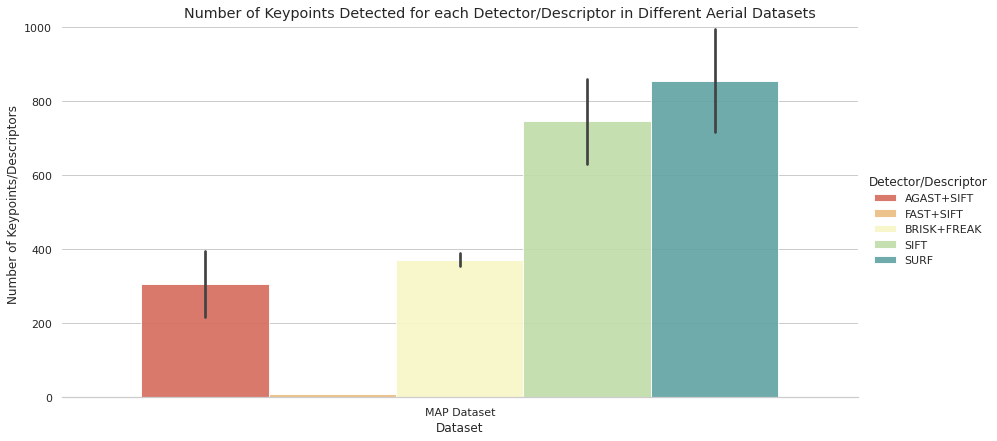

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [60]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [61]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

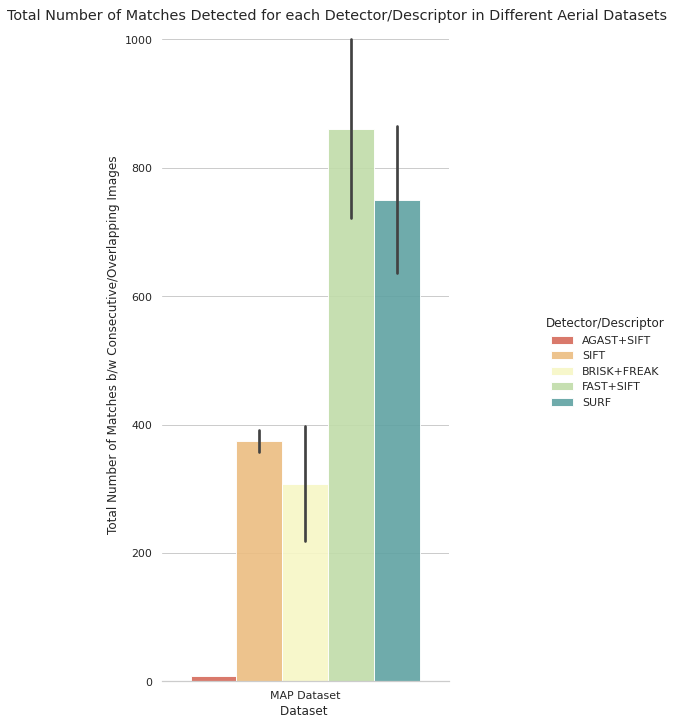

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_5['Number of Good Matches'] = num_good_matches_agast + num_good_matches_fast + num_good_matches_freak + num_good_matches_surf + num_good_matches_sift
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

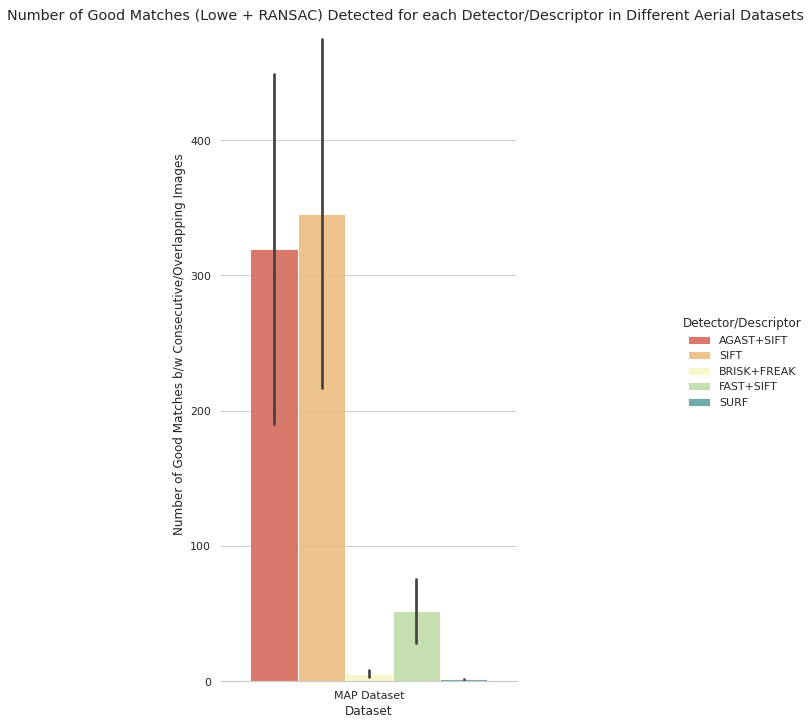

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

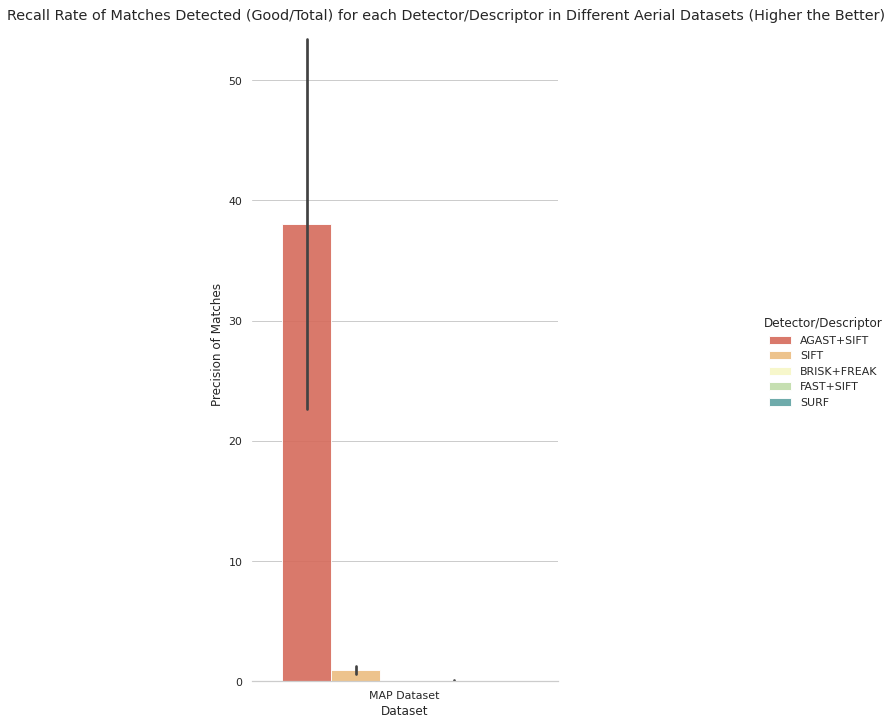

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

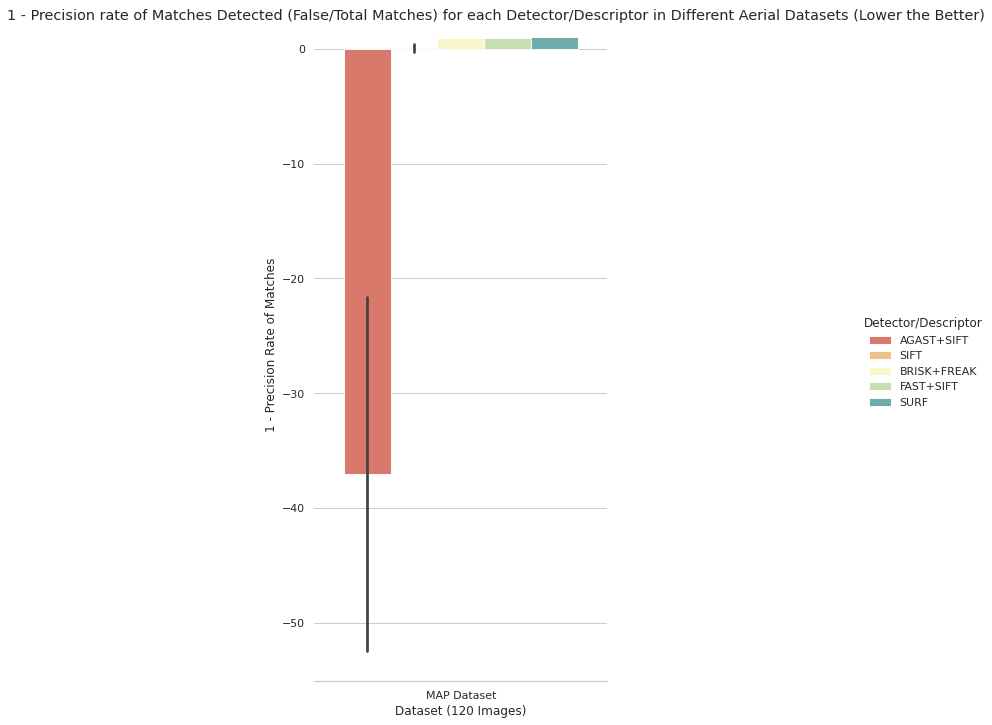

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

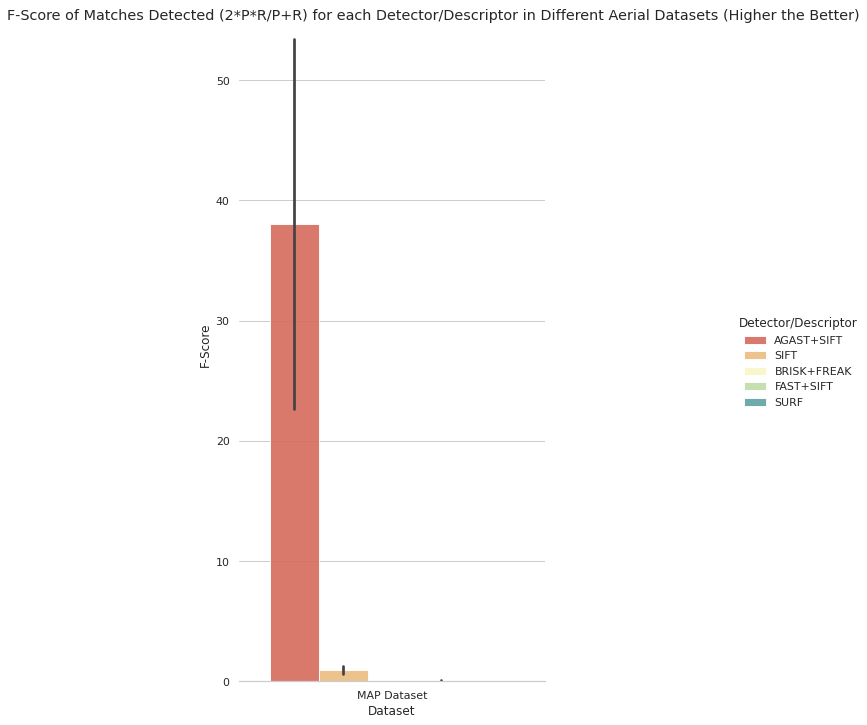

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [71]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [72]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [73]:
print(df_time_5)

       Dataset         Time Detector/Descriptor
0  MAP Dataset   906.180486          AGAST+SIFT
1  MAP Dataset   147.277211           FAST+SIFT
2  MAP Dataset  1039.174159         BRISK+FREAK
3  MAP Dataset   207.217047                SURF
4  MAP Dataset   317.695338                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

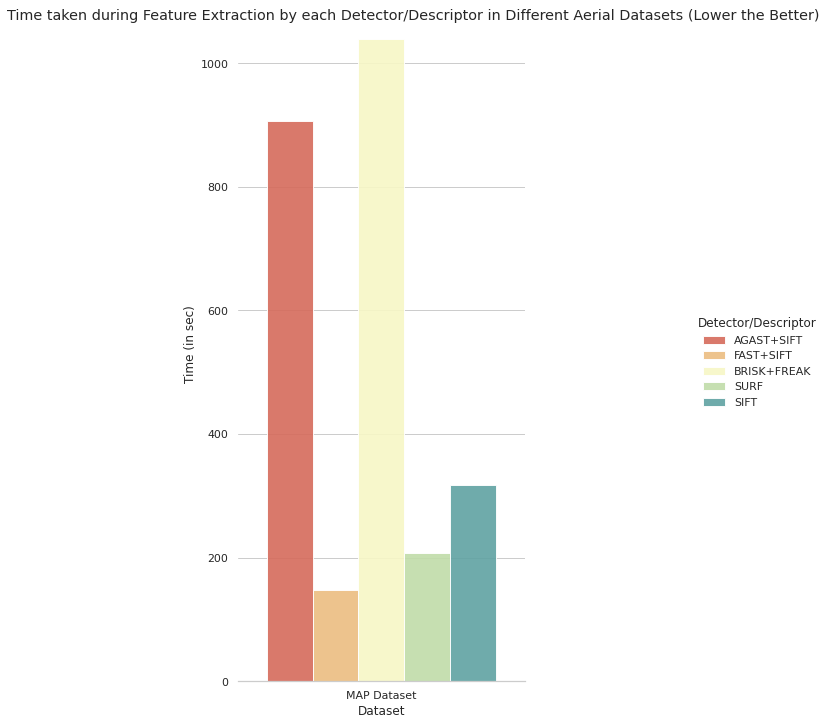

In [75]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [76]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU